In [1]:
import os
import sys
sys.path.append('../Python/')
import config
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import imblearn

from utils import make_ndarray_from_csv, get_int_label
from collections import Counter, OrderedDict
from matplotlib import rcParams
from imblearn.over_sampling import SMOTE, RandomOverSampler

## Config

In [2]:
# Change option so that pandas always display all rows of the dataframe
pd.set_option('display.max_rows', None)

In [3]:
TAKE_MINOR_AT = 26
fold = '1.0'

## Count number of samples for each class

In [4]:
features, labels = make_ndarray_from_csv(fold, mode = 'train')
features.shape, labels.shape

((2204, 10000), (2204,))

In [5]:
labels_count = Counter(labels)

In [6]:
print(labels_count)

Counter({'GBM, RTK II': 114, 'MB, G4': 110, 'LGG, PA PF': 91, 'EPN, PF A': 72, 'MNG': 72, 'MB, SHH CHL AD': 67, 'O IDH': 64, 'DMG, K27': 62, 'A IDH': 62, 'MB, G3': 61, 'EPN, RELA': 56, 'GBM, RTK I': 51, 'GBM, MES': 44, 'MB, SHH INF': 41, 'EPN, PF B': 40, 'ATRT, SHH': 36, 'A IDH, HG': 36, 'PLEX, PED B': 36, 'PXA': 35, 'LGG, DNT': 35, 'ETMR': 34, 'GBM, G34': 32, 'MB, WNT': 31, 'CNS NB, FOXR2': 31, 'LGG, PA MID': 30, 'ATRT, TYR': 29, 'SUBEPN, PF': 29, 'ATRT, MYC': 23, 'PITUI': 23, 'EPN, MPE': 22, 'EPN, SPINE': 21, 'HMB': 20, 'CPH, ADM': 20, 'LGG, PA/GG ST': 19, 'CONTR, INFLAM': 19, 'CONTR, REACT': 18, 'HGNET, BCOR': 18, 'SCHW': 18, 'ENB, A': 18, 'LGG, MYB': 17, 'PIN T,  PB B': 17, 'PTPR, B': 17, 'PLEX, AD': 17, 'HGNET, MN1': 16, 'LGG, SEGA': 16, 'CN': 16, 'CPH, PAP': 16, 'LGG, GG': 16, 'PITAD, FSH LH': 16, 'ANA PA': 16, 'SUBEPN, ST': 15, 'PIN T, PPT': 15, 'PGG, nC': 15, 'RETB': 15, 'PITAD, ACTH': 14, 'PITAD, STH SPA': 13, 'GBM, MYCN': 12, 'ENB, B': 12, 'SFT HMPC': 12, 'MELCYT': 12, 'PLEX,

In [7]:
sorted_labels_count = OrderedDict(labels_count.most_common())
print(sorted_labels_count)

OrderedDict([('GBM, RTK II', 114), ('MB, G4', 110), ('LGG, PA PF', 91), ('EPN, PF A', 72), ('MNG', 72), ('MB, SHH CHL AD', 67), ('O IDH', 64), ('DMG, K27', 62), ('A IDH', 62), ('MB, G3', 61), ('EPN, RELA', 56), ('GBM, RTK I', 51), ('GBM, MES', 44), ('MB, SHH INF', 41), ('EPN, PF B', 40), ('ATRT, SHH', 36), ('A IDH, HG', 36), ('PLEX, PED B', 36), ('PXA', 35), ('LGG, DNT', 35), ('ETMR', 34), ('GBM, G34', 32), ('MB, WNT', 31), ('CNS NB, FOXR2', 31), ('LGG, PA MID', 30), ('ATRT, TYR', 29), ('SUBEPN, PF', 29), ('ATRT, MYC', 23), ('PITUI', 23), ('EPN, MPE', 22), ('EPN, SPINE', 21), ('HMB', 20), ('CPH, ADM', 20), ('LGG, PA/GG ST', 19), ('CONTR, INFLAM', 19), ('CONTR, REACT', 18), ('HGNET, BCOR', 18), ('SCHW', 18), ('ENB, A', 18), ('LGG, MYB', 17), ('PIN T,  PB B', 17), ('PTPR, B', 17), ('PLEX, AD', 17), ('HGNET, MN1', 16), ('LGG, SEGA', 16), ('CN', 16), ('CPH, PAP', 16), ('LGG, GG', 16), ('PITAD, FSH LH', 16), ('ANA PA', 16), ('SUBEPN, ST', 15), ('PIN T, PPT', 15), ('PGG, nC', 15), ('RETB', 1

In [8]:
df = pd.DataFrame.from_dict(sorted_labels_count, orient='index').reset_index()
df = df.rename(columns = {'index':'methylation_class', 0:'samples'})
print(df.to_string())
# df

   methylation_class  samples
0        GBM, RTK II      114
1             MB, G4      110
2         LGG, PA PF       91
3          EPN, PF A       72
4                MNG       72
5     MB, SHH CHL AD       67
6              O IDH       64
7           DMG, K27       62
8              A IDH       62
9             MB, G3       61
10         EPN, RELA       56
11        GBM, RTK I       51
12          GBM, MES       44
13       MB, SHH INF       41
14         EPN, PF B       40
15         ATRT, SHH       36
16         A IDH, HG       36
17       PLEX, PED B       36
18               PXA       35
19          LGG, DNT       35
20              ETMR       34
21          GBM, G34       32
22           MB, WNT       31
23     CNS NB, FOXR2       31
24       LGG, PA MID       30
25         ATRT, TYR       29
26        SUBEPN, PF       29
27         ATRT, MYC       23
28             PITUI       23
29          EPN, MPE       22
30        EPN, SPINE       21
31               HMB       20
32        

## Visualization

In [9]:
classes = np.array(df.iloc[:,0])
n_samples = np.array(df.iloc[:,-1])
counts = df['methylation_class'].value_counts().reset_index(name = 'samples')
print(labels.shape, n_samples.shape)

(2204,) (91,)


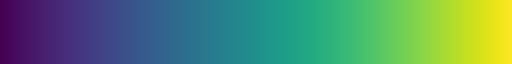

In [10]:
sns.set(font_scale=1)
# test color for sns graph pallette
'''
Possible palette values include:
Name of a seaborn palette (deep, muted, bright, pastel, dark, colorblind)

Name of matplotlib colormap (check here: https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html)

‘husl’ or ‘hls’

‘ch:<cubehelix arguments>’

‘light:<color>’, ‘dark:<color>’, ‘blend:<color>,<color>’,

A sequence of colors in any format matplotlib accepts
'''
graph_palette = "viridis"
sns.color_palette(graph_palette, as_cmap=True)

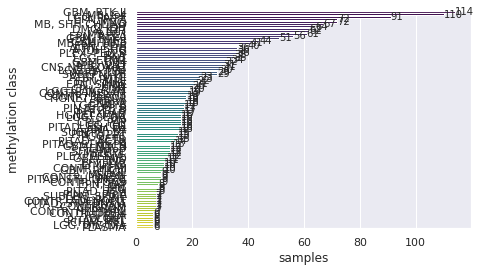

In [11]:
rcParams['figure.figsize'] = 30, 20
graph = sns.barplot(x = n_samples, y = classes, data = counts, palette = graph_palette)
graph.bar_label(graph.containers[0])
graph.set_xlabel("samples")
graph.set_ylabel("methylation class")
plt.show()

## Tackle the imbalanced class distribution

#### SMOTE

In [12]:
X = features
y = np.array([get_int_label(label) for label in labels])

In [13]:
minor_classes = list(sorted_labels_count.keys())[TAKE_MINOR_AT:]
print(minor_classes)

['SUBEPN, PF', 'ATRT, MYC', 'PITUI', 'EPN, MPE', 'EPN, SPINE', 'HMB', 'CPH, ADM', 'LGG, PA/GG ST', 'CONTR, INFLAM', 'CONTR, REACT', 'HGNET, BCOR', 'SCHW', 'ENB, A', 'LGG, MYB', 'PIN T,  PB B', 'PTPR, B', 'PLEX, AD', 'HGNET, MN1', 'LGG, SEGA', 'CN', 'CPH, PAP', 'LGG, GG', 'PITAD, FSH LH', 'ANA PA', 'SUBEPN, ST', 'PIN T, PPT', 'PGG, nC', 'RETB', 'PITAD, ACTH', 'PITAD, STH SPA', 'GBM, MYCN', 'ENB, B', 'SFT HMPC', 'MELCYT', 'PLEX, PED A ', 'GBM, MID', 'EWS', 'EFT, CIC', 'LYMPHO', 'CONTR, HEMI', 'GBM, RTK III', 'CHGL', 'MELAN', 'CONTR, PINEAL', 'PITAD, STH DNS B', 'CONTR, PONS', 'EPN, YAP', 'LIPN', 'IHG', 'PITAD, TSH', 'PIN T,  PB A', 'SUBEPN, SPINE', 'LGG, RGNT', 'CONTR, ADENOPIT', 'PITAD, STH DNS A', 'CONTR, WM', 'CHORDM', 'CONTR, HYPTHAL', 'CONTR, CEBM', 'PTPR, A', 'DLGNT', 'PITAD, PRL', 'SCHW, MEL', 'LGG, DIG/DIA', 'PLASMA']


In [14]:
minor_indexes = []
i = 0
for label in labels:
    if label in minor_classes:
        minor_indexes.append(i)
    i += 1
print(len(minor_indexes))

832


In [15]:
minor_fetures = np.array([features[i] for i in minor_indexes])
minor_labels = np.array([labels[i] for i in minor_indexes])
major_features = np.array([features[i] for i in range(len(features)) if i not in minor_indexes])
major_labels = np.array([labels[i] for i in range(len(features)) if i not in minor_indexes])
print(np.unique(minor_labels), len(np.unique(minor_labels)))
print(np.unique(major_labels), len(np.unique(major_labels)))
print(len(minor_fetures), len(major_features))
print(len(minor_labels), len(major_features))

['ANA PA' 'ATRT, MYC' 'CHGL' 'CHORDM' 'CN' 'CONTR, ADENOPIT' 'CONTR, CEBM'
 'CONTR, HEMI' 'CONTR, HYPTHAL' 'CONTR, INFLAM' 'CONTR, PINEAL'
 'CONTR, PONS' 'CONTR, REACT' 'CONTR, WM' 'CPH, ADM' 'CPH, PAP' 'DLGNT'
 'EFT, CIC' 'ENB, A' 'ENB, B' 'EPN, MPE' 'EPN, SPINE' 'EPN, YAP' 'EWS'
 'GBM, MID' 'GBM, MYCN' 'GBM, RTK III' 'HGNET, BCOR' 'HGNET, MN1' 'HMB'
 'IHG' 'LGG, DIG/DIA' 'LGG, GG' 'LGG, MYB' 'LGG, PA/GG ST' 'LGG, RGNT'
 'LGG, SEGA' 'LIPN' 'LYMPHO' 'MELAN' 'MELCYT' 'PGG, nC' 'PIN T,  PB A'
 'PIN T,  PB B' 'PIN T, PPT' 'PITAD, ACTH' 'PITAD, FSH LH' 'PITAD, PRL'
 'PITAD, STH DNS A' 'PITAD, STH DNS B' 'PITAD, STH SPA' 'PITAD, TSH'
 'PITUI' 'PLASMA' 'PLEX, AD' 'PLEX, PED A ' 'PTPR, A' 'PTPR, B' 'RETB'
 'SCHW' 'SCHW, MEL' 'SFT HMPC' 'SUBEPN, PF' 'SUBEPN, SPINE' 'SUBEPN, ST'] 65
['A IDH' 'A IDH, HG' 'ATRT, SHH' 'ATRT, TYR' 'CNS NB, FOXR2' 'DMG, K27'
 'EPN, PF A' 'EPN, PF B' 'EPN, RELA' 'ETMR' 'GBM, G34' 'GBM, MES'
 'GBM, RTK I' 'GBM, RTK II' 'LGG, DNT' 'LGG, PA MID' 'LGG, PA PF' 'MB, G3'
 '

In [16]:
X_minor = minor_fetures
y_minor = minor_labels
X_major = major_features
y_major = major_labels

In [17]:
smote = SMOTE(sampling_strategy = "auto", random_state = 42)
new_X_minor, new_y_minor = smote.fit_resample(X_minor, y_minor)

In [18]:
print(type(new_X_minor), type(new_y_minor), len(new_X_minor), len(new_y_minor))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 1885 1885


In [19]:
new_X = np.append(X_major, new_X_minor, axis = 0)
new_y = np.append(y_major, new_y_minor)
print(len(new_X), len(new_y))

3257 3257
